# Make some density shells

In [6]:
import numpy as np
from bnt_smooth import LognormalWeakLensingSim

In [7]:
# --- Define a parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 1234
l_max = 1024
lognormal_shift = 1.0
zmax = 3.0
nslices = 50

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    zmax=zmax,
    nslices=nslices
)

# --- Generate lognormal matter fields from scratch ---
maps = sim.generate_matter_fields_from_scratch()

# --- Print summary ---
print(f"Generated {len(maps)} lognormal HEALPix maps.")
print(f"Each map has {maps[0].size} pixels (nside = {sim.nside})")

Generated 50 lognormal HEALPix maps.
Each map has 12582912 pixels (nside = 1024)


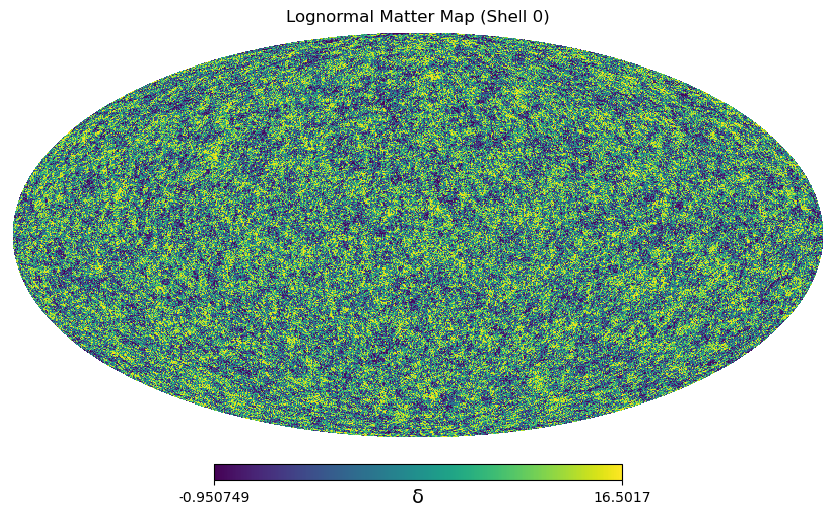

In [8]:
import healpy as hp
import matplotlib.pyplot as plt

# --- Plot the first map (shell 0) ---
hp.mollview(maps[4], title="Lognormal Matter Map (Shell 0)", unit="δ", norm='hist')
plt.show()


# Use these to compute kappa maps

Generated 50 lognormal matter maps.
Computed 3 κ-maps (one per tomographic bin).


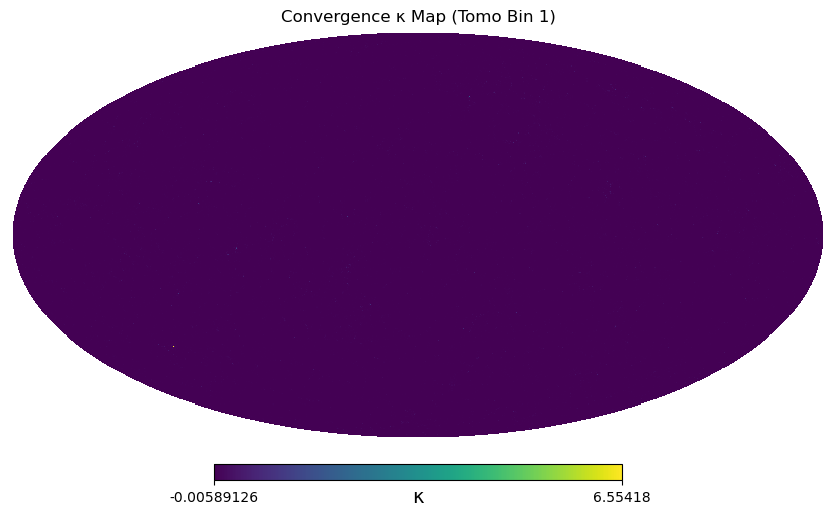

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 42
l_max = 1024
lognormal_shift = 1.0
zmax = 3.0
nslices = 50

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    zmax=zmax,
    nslices=nslices
)

# --- Step 1: Generate lognormal matter fields ---
matter_maps = sim.generate_matter_fields_from_scratch()
print(f"Generated {len(matter_maps)} lognormal matter maps.")

# --- Step 2: Compute kappa maps for each tomographic bin ---
kappa_maps = sim.compute_kappa_maps(matter_maps)
print(f"Computed {len(kappa_maps)} κ-maps (one per tomographic bin).")

# --- Step 3: Plot the first κ-map ---
hp.mollview(kappa_maps[0], title="Convergence κ Map (Tomo Bin 1)", unit="κ")
plt.show()

# Let's see what happens to the histogram for different values of the lognormal shift parameter

Computing κ map with lognormal_shift = 0.7
Computing κ map with lognormal_shift = 1.0
Computing κ map with lognormal_shift = 1.3
0.003800059168063684
0.005461023740513834
0.0070875711012139


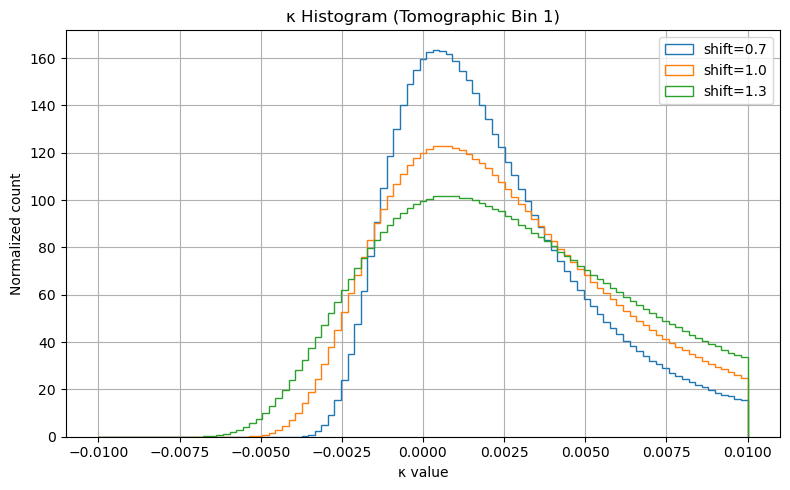

In [10]:
import matplotlib.pyplot as plt

# --- Define shift values to compare ---
shifts = [0.7, 1.0, 1.3, ]
hist_data = []

for shift in shifts:
    print(f"Computing κ map with lognormal_shift = {shift}")
    
    # Set shift and regenerate matter maps
    sim.lognormal_shift = shift
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust range as needed

for i, kappa in enumerate(hist_data):
    print (np.mean(kappa))
    plt.hist(kappa, bins=bins, histtype='step', label=f'shift={shifts[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1)")
plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# visualise what happens for different values of the baryonic feedback parameter

Computing κ map with baryon_feedback = 7.6
Computing κ map with baryon_feedback = 8.0
Computing κ map with baryon_feedback = 8.1
Mean κ for feedback=7.6: 7.1818e-03
Mean κ for feedback=8.0: 7.0658e-03
Mean κ for feedback=8.1: 7.1791e-03


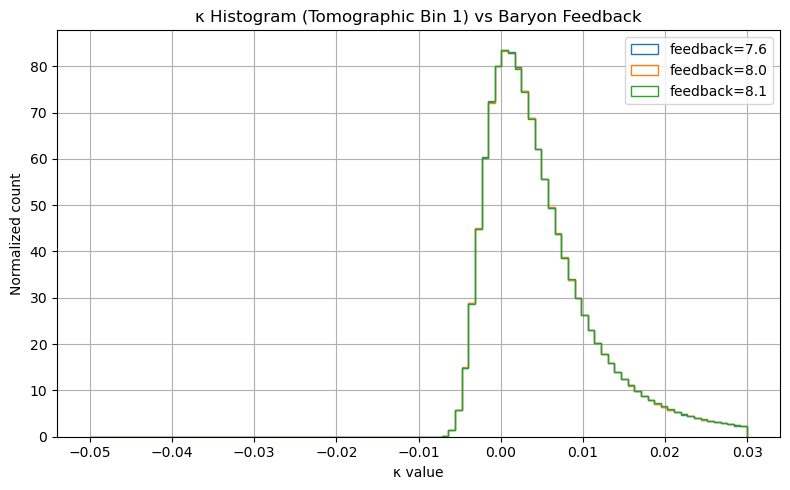

In [11]:
import matplotlib.pyplot as plt

# --- Define baryonic feedback values to compare ---
feedback_values = [7.6, 8.0, 8.1]
hist_data = []

for feedback in feedback_values:
    print(f"Computing κ map with baryon_feedback = {feedback}")
    
    # Set feedback parameter and regenerate matter maps
    sim.baryon_feedback = feedback
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.05, 0.03, 100)  # Adjust as needed

for i, kappa in enumerate(hist_data):
    print(f"Mean κ for feedback={feedback_values[i]}: {np.mean(kappa):.4e}")
    plt.hist(kappa, bins=bins, histtype='step', label=f'feedback={feedback_values[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1) vs Baryon Feedback")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Computing κ map with baryon_feedback = 7.71
Computing κ map with baryon_feedback = 8.0
Computing κ map with baryon_feedback = 8.2


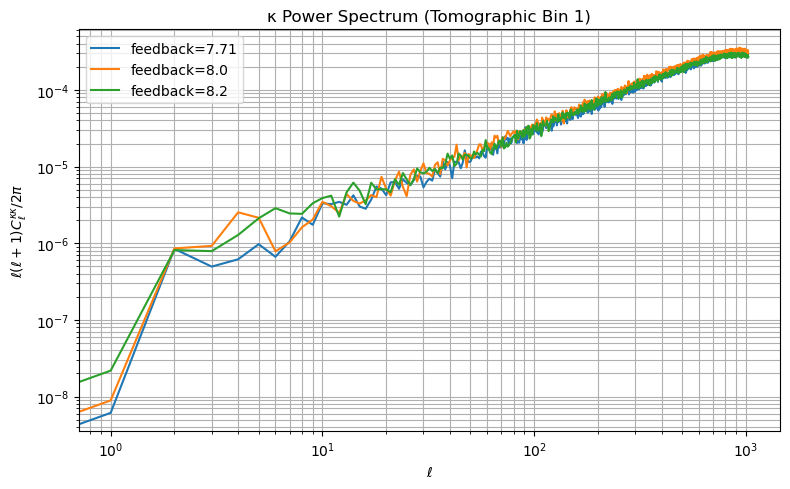

In [12]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np

# --- Define baryonic feedback values to compare ---
feedback_values = [7.71, 8.0, 8.2]
cl_list = []
lmax_plot = sim.l_max


for feedback in feedback_values:
    print(f"Computing κ map with baryon_feedback = {feedback}")
    
    # Set feedback and regenerate maps
    sim.baryon_feedback = feedback
    matter_maps = sim.generate_matter_fields_from_scratch()
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Compute power spectrum of the first κ map
    cl = hp.anafast(kappa_maps[0], lmax=lmax_plot)
    ell = np.arange(len(cl))
    cl_list.append((ell, cl))

# --- Plot the κ power spectra ---
plt.figure(figsize=(8, 5))
for i, (ell, cl) in enumerate(cl_list):
    plt.plot(ell, ell * (ell + 1) * cl / (2 * np.pi), label=f'feedback={feedback_values[i]}')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_\ell^{\kappa\kappa} / 2\pi$')
plt.title(r'κ Power Spectrum (Tomographic Bin 1)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

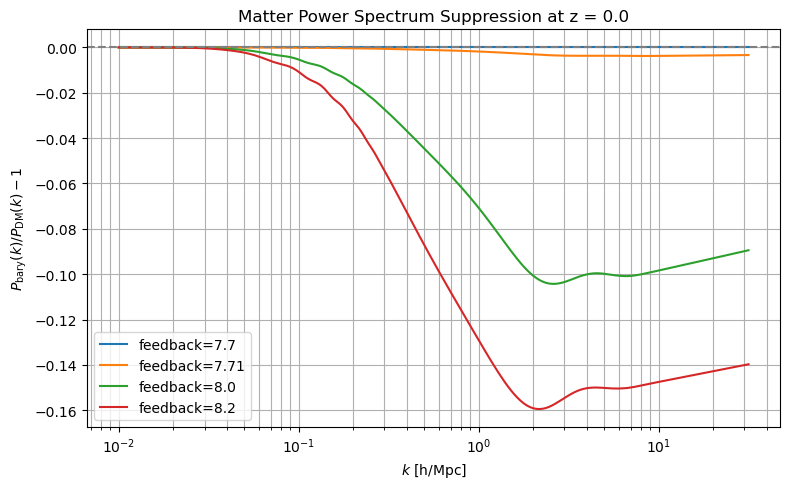

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl

# --- Feedback models to compare ---
feedback_values = [7.7, 7.71, 8.0, 8.2]

# --- Common cosmology setup ---
cosmo_params = {
    "Omega_c": 0.25,
    "Omega_b": 0.05,
    "h": 0.67,
    "n_s": 0.96,
    "sigma8": 0.8,
}

# --- Redshift and k-range ---
z = 0.
k = np.logspace(-2, 1.5, 200)  # [h/Mpc]

# --- Compute P_bary(k) and P_DM(k) ---
P_dm = None
suppression_list = []

for feedback in feedback_values:
    cosmo = ccl.Cosmology(
        Omega_c=cosmo_params["Omega_c"],
        Omega_b=cosmo_params["Omega_b"],
        h=cosmo_params["h"],
        n_s=cosmo_params["n_s"],
        sigma8=cosmo_params["sigma8"],
        matter_power_spectrum="camb",
        extra_parameters = {"camb": {"halofit_version": "mead2020_feedback",
                             "HMCode_logT_AGN": feedback}}
    )
    pk = ccl.nonlin_matter_power(cosmo, k, 1 / (1 + z)) # Nonlinear includes feedback suppression
    if P_dm is None:
        # Save the "dark-matter only" case as the baseline (use feedback = 0 if needed)
        P_dm = pk

    suppression = pk / P_dm - 1
    suppression_list.append(suppression)

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, fb in enumerate(feedback_values):
    plt.plot(k, suppression_list[i], label=f'feedback={fb}')

plt.xscale('log')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P_{\mathrm{bary}}(k)/P_{\mathrm{DM}}(k) - 1$')
plt.title(f'Matter Power Spectrum Suppression at z = {z}')
plt.axhline(0, color='gray', ls='--')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

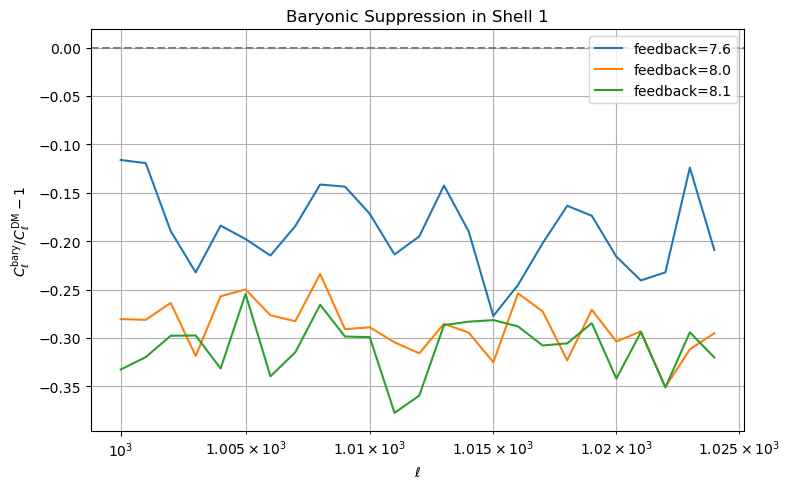

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# --- Define baryonic feedback values ---
feedback_values = [7.6, 8.0, 8.1]
cl_ratios = []
lmax = sim.l_max  # assuming sim is already initialized

# --- Compute reference dark matter Cl ---
sim.baryon_feedback = 0.0  # no suppression = DM-only
dm_maps = sim.generate_matter_fields_from_scratch()
dm_cl = hp.anafast(dm_maps[0], lmax=lmax)
ell = np.arange(len(dm_cl))

# --- Loop over baryon models ---
for fb in feedback_values:
    sim.baryon_feedback = fb
    bary_maps = sim.generate_matter_fields_from_scratch()
    bary_cl = hp.anafast(bary_maps[0], lmax=lmax)

    ratio = bary_cl / dm_cl - 1
    cl_ratios.append(ratio)

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, fb in enumerate(feedback_values):
    ell_cut = ell[ell >= 1000]
    ratio_cut = cl_ratios[i][ell >= 1000]
    plt.plot(ell_cut, ratio_cut, label=f'feedback={fb}')

plt.axhline(0, color='gray', ls='--')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\mathrm{bary}} / C_\ell^{\mathrm{DM}} - 1$')
plt.title('Baryonic Suppression in Shell 1')
plt.xscale('log')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# --- Define baryonic feedback values ---
feedback_values = [7.6, 8.0, 8.1]
cl_ratios = []
lmax = sim.l_max  # assuming sim is already initialized

# --- Compute reference dark matter Cl ---
sim.baryon_feedback = 0.0  # no suppression = DM-only
dm_maps = sim.generate_matter_fields_from_scratch()
dm_cl = hp.anafast(dm_maps[0], lmax=lmax)
ell = np.arange(len(dm_cl))

# --- Loop over baryon models ---
for fb in feedback_values:
    sim.baryon_feedback = fb
    bary_maps = sim.generate_matter_fields_from_scratch()
    bary_cl = hp.anafast(bary_maps[0], lmax=lmax)

    ratio = bary_cl / dm_cl - 1
    cl_ratios.append(ratio)

# --- Plot ---
plt.figure(figsize=(8, 5))
for i, fb in enumerate(feedback_values):
    ell_cut = ell[ell >= 1000]
    ratio_cut = cl_ratios[i][ell >= 1000]
    plt.plot(ell_cut, ratio_cut, label=f'feedback={fb}')

plt.axhline(0, color='gray', ls='--')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\mathrm{bary}} / C_\ell^{\mathrm{DM}} - 1$')
plt.title('Baryonic Suppression in Shell 1')
plt.xscale('log')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_20410/3136521289.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nz /= np.trapz(nz, z)


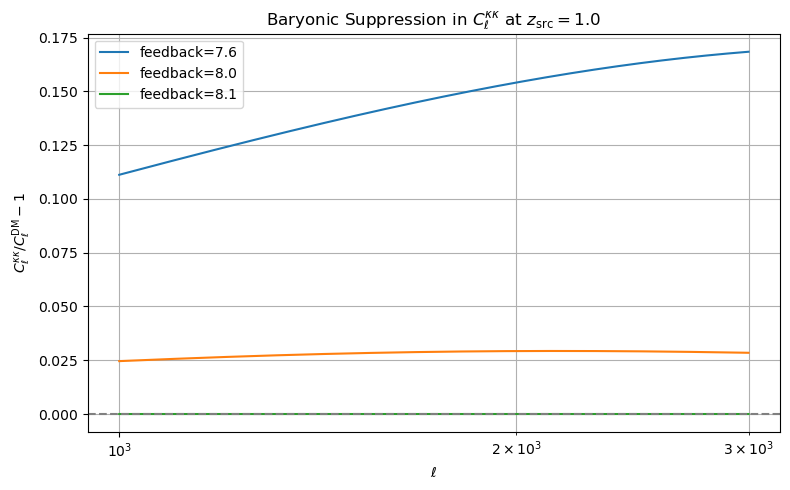

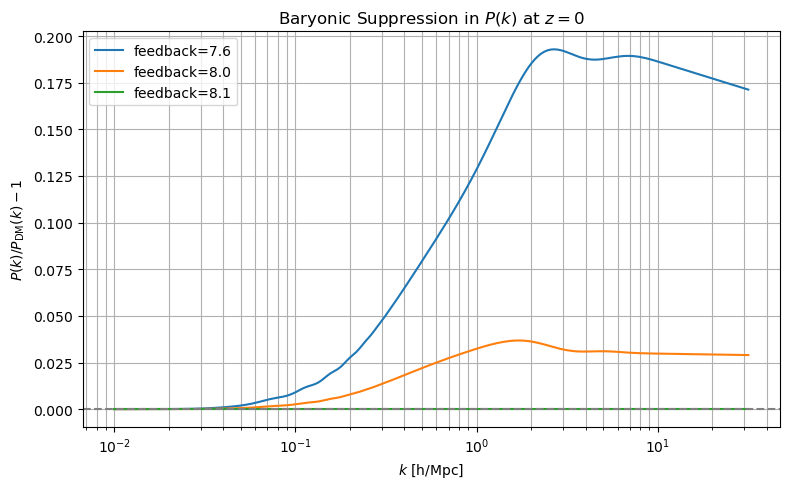

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl

# --- Feedback scenarios to compare ---
feedback_values = [7.6, 8.0, 8.1]
lmax = 3000
ell = np.arange(2, lmax + 1)
z_src = 1.0
z_pk = 0.0
k = np.logspace(-2, 1.5, 200)  # h/Mpc
a_pk = 1.0  # corresponds to z = 0

# --- Base cosmology ---
cosmo_params = {
    "Omega_c": 0.25,
    "Omega_b": 0.05,
    "h": 0.67,
    "n_s": 0.96,
    "sigma8": 0.8,
}

# --- Source redshift distribution: narrow Gaussian around z_src ---
z = np.linspace(z_src - 0.05, z_src + 0.05, 100)
nz = np.exp(-0.5 * ((z - z_src) / 0.01) ** 2)
nz /= np.trapz(nz, z)

# --- Compute DM-only reference ---
cosmo_dm = ccl.Cosmology(
    **cosmo_params,
    matter_power_spectrum="camb",
    extra_parameters = {"camb": {"halofit_version": "mead2020_feedback",
                             "HMCode_logT_AGN": fb}}
)
tracer_dm = ccl.WeakLensingTracer(cosmo_dm, dndz=(z, nz))
cl_dm = ccl.angular_cl(cosmo_dm, tracer_dm, tracer_dm, ell)
pk_dm = ccl.nonlin_matter_power(cosmo_dm, k, a_pk)

# --- Compute baryon suppression ---
cl_ratios = []
pk_ratios = []

for fb in feedback_values:
    cosmo_fb = ccl.Cosmology(
        **cosmo_params,
        matter_power_spectrum="camb",
        extra_parameters = {"camb": {"halofit_version": "mead2020_feedback",
                             "HMCode_logT_AGN": fb}}
    )
    tracer_fb = ccl.WeakLensingTracer(cosmo_fb, dndz=(z, nz))
    cl_fb = ccl.angular_cl(cosmo_fb, tracer_fb, tracer_fb, ell)
    pk_fb = ccl.nonlin_matter_power(cosmo_fb, k, a_pk)

    cl_ratios.append(cl_fb / cl_dm - 1)
    pk_ratios.append(pk_fb / pk_dm - 1)

# --- Plot κ power spectrum suppression ---
plt.figure(figsize=(8, 5))
for i, fb in enumerate(feedback_values):
    ell_cut = ell[ell >= 1000]
    ratio_cut = cl_ratios[i][ell >= 1000]
    plt.plot(ell_cut, ratio_cut, label=f'feedback={fb}')

plt.axhline(0, color='gray', ls='--')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\kappa\kappa} / C_\ell^{\mathrm{DM}} - 1$')
plt.title(r'Baryonic Suppression in $C_\ell^{\kappa\kappa}$ at $z_\mathrm{src}=1.0$')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot matter power spectrum suppression at z = 0 ---
plt.figure(figsize=(8, 5))
for i, fb in enumerate(feedback_values):
    plt.plot(k, pk_ratios[i], label=f'feedback={fb}')

plt.axhline(0, color='gray', ls='--')
plt.xscale('log')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)/P_{\mathrm{DM}}(k) - 1$')
plt.title(r'Baryonic Suppression in $P(k)$ at $z = 0$')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
cosmo

<pyccl.cosmology.Cosmology>
	Neff    = 3.044
	Omega_b = 0.05
	Omega_c = 0.25
	h       = 0.67
	n_s     = 0.96
	sigma8  = 0.8
	matter_power_spectrum = camb
	extra_parameters =
		camb = {'HMCode_logT_AGN': 8.2, 'halofit_version': 'mead2020_feedback'}
	HASH_ACCURACY_PARAMS = 0xe308991c3c8289b

In [13]:
sim.baryon_feedback

8.1

In [7]:
sim.cosmo

TypeError: 'float' object is not iterable

In [8]:
sim

In [4]:
# --- Define a parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 1234
l_max = 256
lognormal_shift = 1.0
zmax = 3.0
nslices = 50

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    zmax=zmax,
    nslices=nslices
)

In [5]:
sim.cosmo

<pyccl.cosmology.Cosmology>
	Neff    = 3.044
	Omega_b = 0.05
	Omega_c = 0.25
	h       = 0.67
	n_s     = 0.96
	sigma8  = 0.8
	matter_power_spectrum = camb
	extra_parameters =
		camb = {'HMCode_logT_AGN': 3.13, 'halofit_version': 'mead2020_feedback'}
	HASH_ACCURACY_PARAMS = 0xf166ebdcac5d1827